In [ ]:
'''
loading config
'''

from config import DATA_DIR, METADATA_PATH, OUTPUT_DIR, VISUALS_DIR, CSV_DIR, NUM_TOPICS, MAX_DF, MIN_DF
import os

for path in [OUTPUT_DIR, VISUALS_DIR, CSV_DIR]:
    os.makedirs(path, exist_ok=True)

In [ ]:
'''
loading text chunks
'''

from pathlib import Path

texts = []
filenames = []

for file in sorted(DATA_DIR.glob("*.txt")):
    with open(file, "r", encoding="utf-8") as f:
        texts.append(f.read())
        filenames.append(file.name)

In [49]:
# Preprocessing using spaCy

import spacy

# load German spacy model
nlp = spacy.load("de_core_news_sm")  # or "de_core_news_md" / "de_core_news_lg" or "de_core_news_sm"

def preprocess(text):
    doc = nlp(text)
    return " ".join([
        token.lemma_.lower()
        for token in doc
        if token.pos_ in ["NOUN", "VERB", "ADJ"]
        and not token.is_stop
        and token.is_alpha
    ])

texts_cleaned = [preprocess(text) for text in texts]

In [50]:
# vectorizing

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=MAX_DF, min_df=MIN_DF)
X = vectorizer.fit_transform(texts_cleaned)

In [51]:
# LDA training

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=NUM_TOPICS, random_state=42)
lda.fit(X)

LatentDirichletAllocation(random_state=42)

## topics

In [52]:
def print_topics(model, vectorizer, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic #{idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-top_n - 1:-1]]))

print_topics(lda, vectorizer)


Topic #0:
kaiser mauer bau sehen dorf wissen leben volk mann heimat

Topic #1:
offizier reisend verurteilter soldat kommandant hand reisende apparat sehen mann

Topic #2:
herr diener tür akte gang bleiben scheinen wirt zimmer wirtin

Topic #3:
klamm wissen wirtin arbeit sehen scheinen herr glauben sagen fragen

Topic #4:
delamarch fragen lehrer hund mann halten scheinen gehilfe rufen frage

Topic #5:
advokat kaufmann fragen block hand theater sprechen prozeß wissen pferd

Topic #6:
welt leben mensch glauben böse herr haus weg alt wissen

Topic #7:
herr zimmer hand tür vater wissen sehen fragen sagen scheinen

Topic #8:
herr hand fragen mann tür frau sehen prozeß gericht glauben

Topic #9:
onkel hand fragen sehen freund delamarch koffer wissen herr scheinen


In [ ]:

'''Script for getting the topic distributions'''

import pandas as pd
import matplotlib.pyplot as plt
from config import CSV_DIR, VISUALS_DIR, NUM_TOPICS
import os

# creating output directories if not existing already
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(VISUALS_DIR, exist_ok=True)

# creating topic names
topic_names = [f"Topic {k}" for k in range(NUM_TOPICS)]
vocabulary = vectorizer.get_feature_names_out()

# topic-word-distribution
topic_word_distributions = pd.DataFrame(
    lda.components_, columns=vocabulary, index=topic_names
)

# document-topic-distribution
document_topic_matrix = lda.transform(X)
document_topic_distributions = pd.DataFrame(
    document_topic_matrix, columns=topic_names, index=filenames
)

# save DataFrames
topic_word_distributions.to_csv(CSV_DIR / "topic_word_distributions.csv")
document_topic_distributions.to_csv(CSV_DIR / "document_topic_distributions.csv")


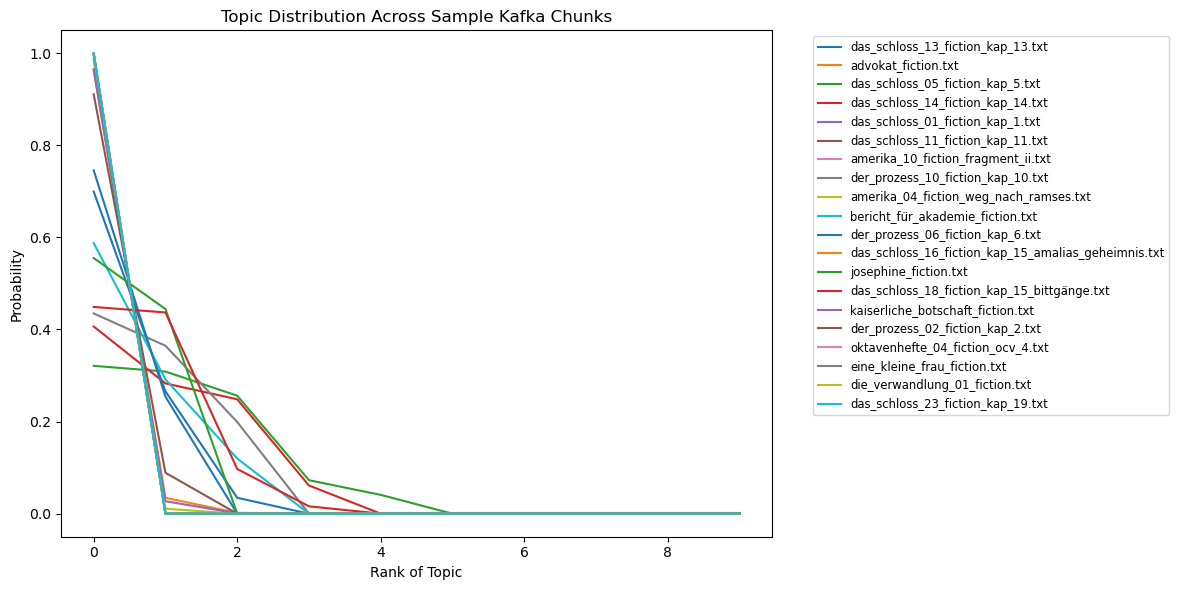

In [61]:
# visualizing topic ranks for a random sample
sampled = document_topic_distributions.sample(20, random_state=42)
weights_ordered = sampled.apply(lambda row: row.sort_values(ascending=False).reset_index(drop=True), axis=1)

ax = weights_ordered.T.plot(figsize=(12, 6), legend=True)
ax.legend(sampled.index, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small")
ax.set(xlabel='Rank of Topic', ylabel='Probability', title='Topic Distribution Across Sample Kafka Chunks')
plt.tight_layout()
plt.savefig(VISUALS_DIR / "kafka_topic_distribution_labeled.png")
plt.show()

In [27]:
df_k = pd.read_csv("/Users/arashalborz/PROJECTS/kafka_topic_modeling/data/kafka_metadata.csv")
df_k.shape

(80, 1)

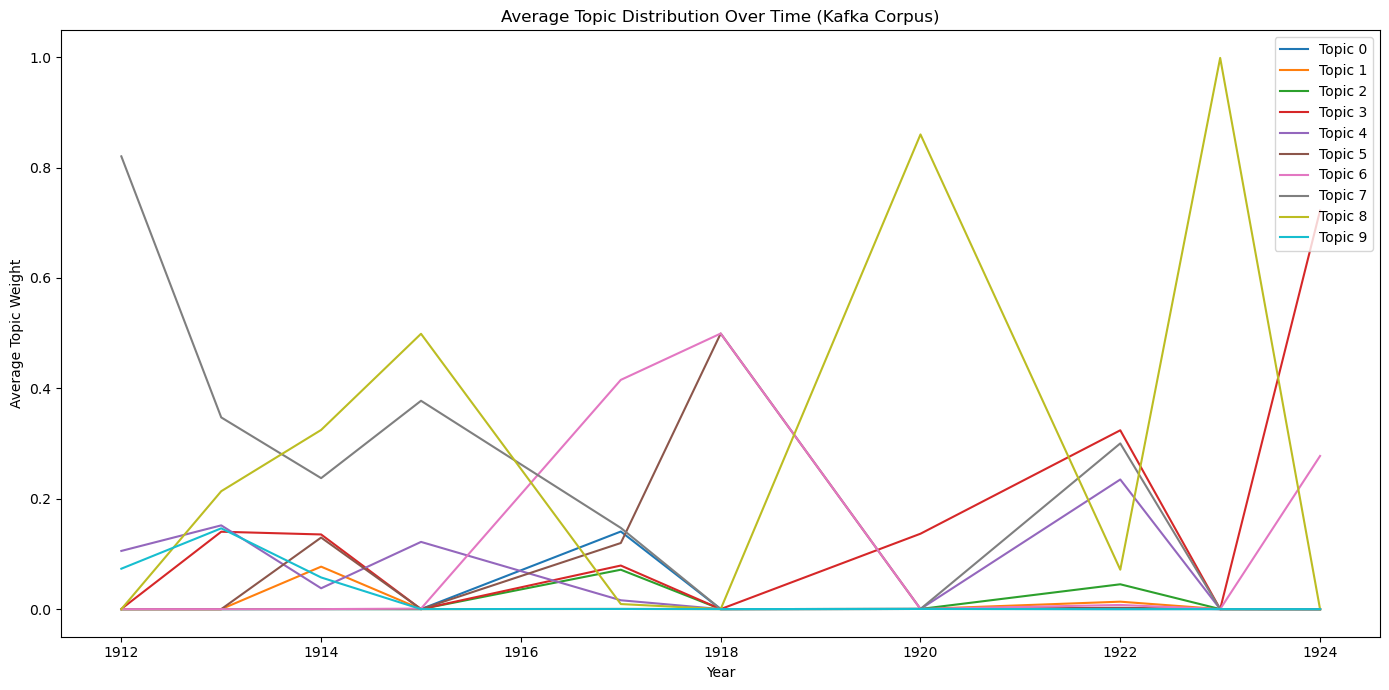

In [30]:

import os
import pandas as pd
from pathlib import Path
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# === Load metadata ===
metadata = pd.read_csv("/Users/arashalborz/PROJECTS/kafka_topic_modeling/data/kafka_metadata.csv", sep=";")
metadata['word_count'] = pd.to_numeric(metadata['word_count'], errors='coerce')
metadata['year'] = pd.to_numeric(metadata['year'], errors='coerce')

# === Load texts ===
data_dir = Path("/Users/arashalborz/PROJECTS/kafka_topic_modeling/data/raw_chunks/")
texts = []
filenames = []

for file in sorted(data_dir.glob("*.txt")):
    with open(file, "r", encoding="utf-8") as f:
        texts.append(f.read())
        filenames.append(file.name)

# === Load spaCy model ===
import spacy
try:
    nlp = spacy.load("de_core_news_sm")
except:
    print("Run: python -m spacy download de_core_news_sm")
    raise

# === Preprocess ===
def preprocess(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if token.pos_ in ["NOUN", "VERB", "ADJ"]
        and not token.is_stop
        and token.is_alpha
    ]
    return " ".join(tokens)

texts_cleaned = [preprocess(text) for text in texts]

# === Vectorize ===
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
X = vectorizer.fit_transform(texts_cleaned)

# === Fit LDA ===
lda = LatentDirichletAllocation(n_components=10, random_state=42)
document_topic_matrix = lda.fit_transform(X)

# === Create topic dataframe ===
topic_names = [f"Topic {k}" for k in range(10)]
document_topic_distributions = pd.DataFrame(document_topic_matrix, columns=topic_names)
document_topic_distributions["filename"] = filenames

# === Merge with metadata ===
metadata["filename"] = metadata["filename"].str.strip()
merged = pd.merge(document_topic_distributions, metadata, on="filename", how="inner")

# === Group by year ===
topics_by_year = merged.groupby("year")[topic_names].mean()

# === Plot ===
plt.figure(figsize=(14, 7))
for topic in topic_names:
    plt.plot(topics_by_year.index, topics_by_year[topic], label=topic)

plt.title("Average Topic Distribution Over Time (Kafka Corpus)")
plt.xlabel("Year")
plt.ylabel("Average Topic Weight")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("kafka_topics_over_time.png")
plt.show()


In [31]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load merged topic and metadata dataframe (assumes you've already created this)
metadata = pd.read_csv("/Users/arashalborz/PROJECTS/kafka_topic_modeling/data/kafka_metadata.csv", sep=";")
metadata['word_count'] = pd.to_numeric(metadata['word_count'], errors='coerce')
metadata['year'] = pd.to_numeric(metadata['year'], errors='coerce')

document_topic_distributions = pd.read_csv("document_topic_distributions.csv")  # You should save this earlier
document_topic_distributions["filename"] = document_topic_distributions["filename"].str.strip()

# Merge
merged = pd.merge(document_topic_distributions, metadata, on="filename", how="inner")

# Group by year
topic_names = [col for col in document_topic_distributions.columns if "Topic" in col]
topics_by_year = merged.groupby("year")[topic_names].mean()

# Apply rolling average to smooth
topics_smoothed = topics_by_year.rolling(window=2, min_periods=1).mean()

# Plot
plt.figure(figsize=(14, 7))
for topic in topic_names:
    plt.plot(topics_smoothed.index, topics_smoothed[topic], label=topic, marker='o')

    # Find peak year for this topic
    peak_year = topics_smoothed[topic].idxmax()
    peak_val = topics_smoothed[topic].max()
    if peak_val > 0.3:  # Only label prominent peaks
        plt.text(peak_year, peak_val + 0.02, f"{topic} ({peak_year})", fontsize=9, ha='center')

plt.title("Smoothed Topic Distribution Over Time with Peaks (Kafka Corpus)")
plt.xlabel("Year")
plt.ylabel("Average Topic Weight")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("kafka_topics_over_time_labeled.png")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'document_topic_distributions.csv'